## Importing Dependencies

In [ ]:
!pip install pyspark
import pandas as pd
import numpy as np
import json
import csv
import pandas as pd
from pyspark import SparkContext, SparkConf, StorageLevel, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e9d72ed38c34814b4e97add6609426db2040c6d1c90de215cafb1481c06b9775
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Importing/Reading files

In [ ]:
business_url = '/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/yelp_academic_dataset_business.json'
checkin_url = '/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/yelp_academic_dataset_checkin.json'
reviews_url = '/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/yelp_academic_dataset_review.json'
tip_url = '/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/yelp_academic_dataset_tip.json'
user_url = '/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/yelp_academic_dataset_user.json'

urls = [business_url, checkin_url, reviews_url, tip_url, user_url]

### Setting up SparkSession and SparkDF

In [ ]:
spark = SparkSession.builder.appName("DBFA Yelp Project").config("spark.logConf", True).getOrCreate()
sContext = spark.sparkContext
sqlContext = SQLContext(sContext)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
sContext

<SparkContext master=local[*] appName=DBFA Yelp Project>

In [ ]:
business_df = sqlContext.read.json(business_url)
business_df = business_df.sample(0.1)

reviews_df = sqlContext.read.json(reviews_url)
reviews_df = reviews_df.sample(0.1)

user_df = sqlContext.read.json(user_url)
user_df = user_df.sample(0.1)

tips_df = sqlContext.read.json(tip_url)
tips_df = tips_df.sample(0.1)

checkin_df = sqlContext.read.json(checkin_url)
checkin_df = checkin_df.sample(0.1)


In [ ]:
checkin_df.printSchema()

In [ ]:
business_df.printSchema()

In [ ]:
reviews_df.printSchema()

In [ ]:
user_df.printSchema()

In [ ]:
tips_df.printSchema()

In [ ]:
business_df.createOrReplaceTempView('business')
reviews_df.createOrReplaceTempView('reviews')
user_df.createOrReplaceTempView('users')
tips_df.createOrReplaceTempView('tips')
checkin_df.createOrReplaceTempView('hours')

In [ ]:
print(business_df.count())
spark.sql('SELECT COUNT(1) as businesses from business').show()

150346
+----------+
|businesses|
+----------+
|    150346|
+----------+



In [ ]:
spark.sql('SELECT state, ROUND(AVG(review_count)) as avg_reviews from business GROUP BY state ORDER BY avg_reviews DESC LIMIT 10').show()

+-----+-----------+
|state|avg_reviews|
+-----+-----------+
|   LA|       75.0|
|   CA|       65.0|
|   NV|       53.0|
|   TN|       50.0|
|   PA|       45.0|
|   MO|       44.0|
|   FL|       43.0|
|   IN|       42.0|
|   AZ|       42.0|
|   SD|       42.0|
+-----+-----------+



## Cleaning and SQL querying

In [ ]:
df_business = pd.read_json(business_url, lines=True)
with open('/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/business.csv', 'w') as f:
    df_business.to_csv(f)

In [ ]:
df = pd.read_json(checkin_url, lines=True)
with open('/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/checkin.csv', 'w') as f:
    df.to_csv(f)

In [ ]:
df = pd.read_json(tip_url, lines=True)
with open('/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/tips.csv', 'w') as f:
    df.to_csv(f)

In [ ]:
df = pd.read_json(user_url, lines=True)
with open('/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/users.csv', 'w') as f:
    df.to_csv(f)

In [ ]:
df = pd.read_json(reviews_url, lines=True)
with open('/content/drive/Shareddrives/Big_Data_project/Yelp_dataset/tips.csv', 'w') as f:
    df.to_csv(f)

In [ ]:
spark.sql(""" SELECT * FROM business
""").show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                NULL|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

In [ ]:
business_count_by_state = spark.sql("""
    SELECT state, COUNT(*) AS business_count
    FROM business
    GROUP BY state
    ORDER BY business_count DESC
""").show()

+-----+--------------+
|state|business_count|
+-----+--------------+
|   PA|         34039|
|   FL|         26330|
|   TN|         12056|
|   IN|         11247|
|   MO|         10913|
|   LA|          9924|
|   AZ|          9912|
|   NJ|          8536|
|   NV|          7715|
|   AB|          5573|
|   CA|          5203|
|   ID|          4467|
|   DE|          2265|
|   IL|          2145|
|   TX|             4|
|   CO|             3|
|   WA|             2|
|   HI|             2|
|   MA|             2|
|   MI|             1|
+-----+--------------+
only showing top 20 rows



##### Top 6 Categories

+--------------------+--------------+
|          categories|category_count|
+--------------------+--------------+
|Beauty & Spas, Na...|          1012|
|  Restaurants, Pizza|           935|
|Nail Salons, Beau...|           934|
|  Pizza, Restaurants|           823|
|Restaurants, Mexican|           728|
|Restaurants, Chinese|           708|
+--------------------+--------------+



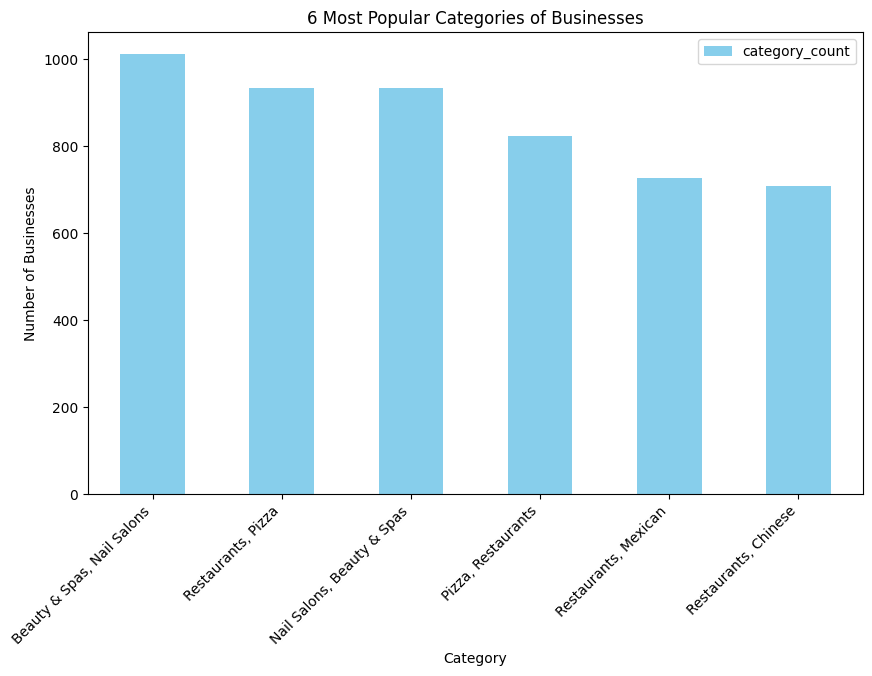

In [ ]:
import matplotlib.pyplot as plt

popular_categories = spark.sql("""
    SELECT categories, COUNT(*) AS category_count
    FROM business
    GROUP BY categories
    ORDER BY category_count DESC
    LIMIT 6
""")

popular_categories.show()

popular_categories_df = popular_categories.toPandas()
popular_categories_df.plot(kind='bar', x='categories', y='category_count', figsize=(10, 6), color='skyblue')
plt.title('6 Most Popular Categories of Businesses')
plt.xlabel('Category')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')
plt.show()


##### Detecting language of the reviws

+-------------+-----+
|         city|Count|
+-------------+-----+
|         Reno|   16|
| Philadelphia|   14|
|        Tampa|   12|
|       Tucson|    9|
|Santa Barbara|    9|
|    Nashville|    5|
|        Boise|    5|
|  Saint Louis|    5|
| Indianapolis|    4|
|   Clearwater|    3|
+-------------+-----+



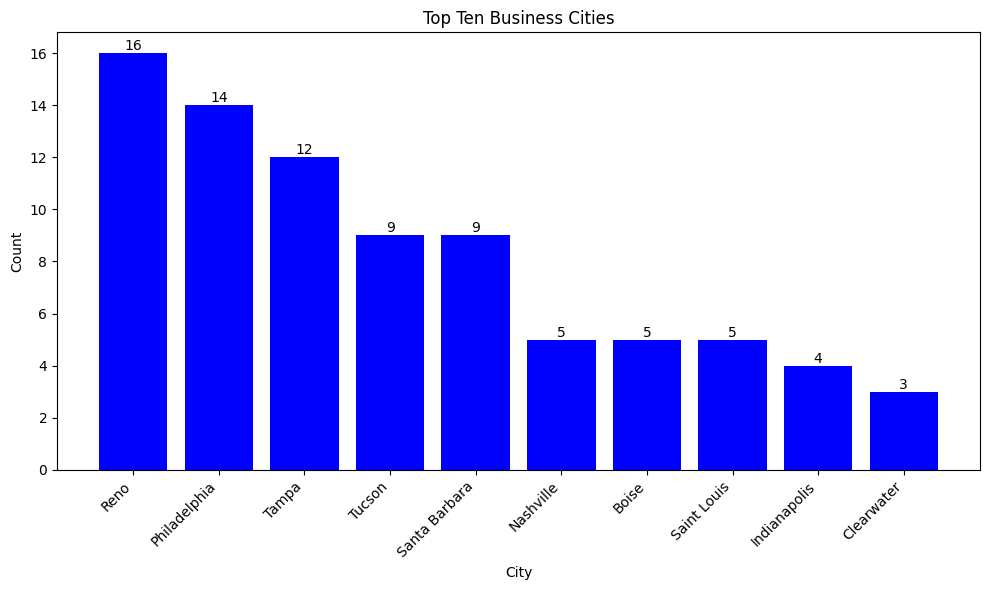

In [ ]:
query_top_ten_cities = """
    SELECT city, COUNT(1) AS Count
    FROM (
        SELECT city
        FROM business
        WHERE lower(categories) LIKE '%business%'
    ) AS business_cities
    GROUP BY city
    ORDER BY Count DESC
    LIMIT 10
"""

top_ten_business_cities = spark.sql(query_top_ten_cities)
top_ten_business_cities.show()

cities = top_ten_business_cities.select("city").rdd.flatMap(lambda x: x).collect()
counts = top_ten_business_cities.select("Count").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
bars = plt.bar(cities, counts, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top Ten Business Cities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Top 10 business with 5-star rating

+--------------------+---------------+
|        BusinessName|FiveStarReviews|
+--------------------+---------------+
|           Starbucks|           5877|
|         First Watch|           4550|
|Reading Terminal ...|           4014|
|        Oceana Grill|           4012|
|   Acme Oyster House|           3979|
|Hattie B’s Hot Ch...|           3838|
|          Los Agaves|           3496|
|         Chick-fil-A|           3473|
|   Ruby Slipper Cafe|           3360|
+--------------------+---------------+



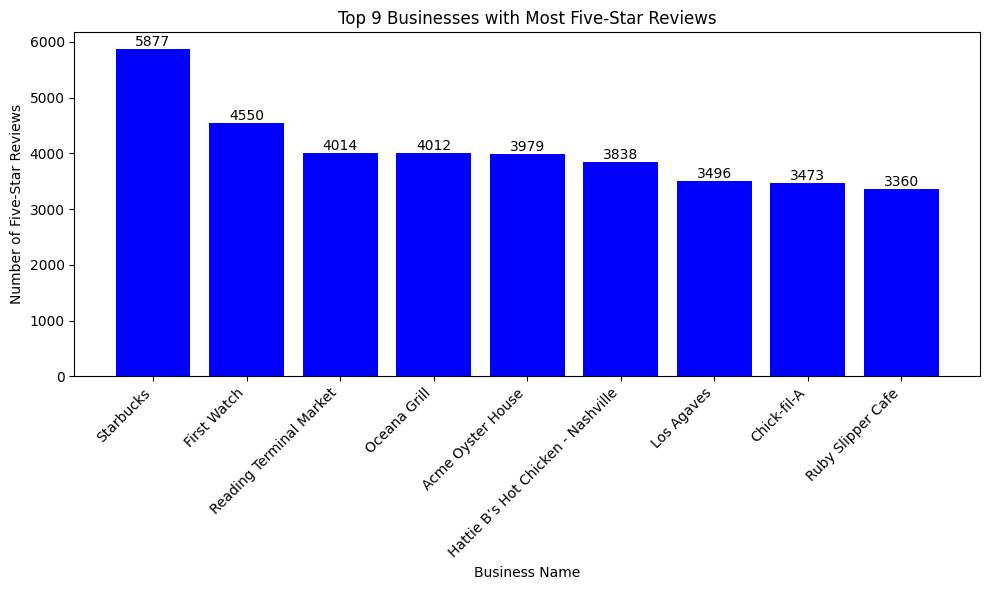

In [ ]:
business_schema = spark.table("business").schema
# print(business_schema)

query_top_n_businesses = """
    SELECT b.name AS BusinessName, COUNT(*) AS FiveStarReviews
    FROM reviews r
    JOIN business b ON r.business_id = b.business_id
    WHERE r.stars = 5
    GROUP BY b.name
    ORDER BY FiveStarReviews DESC
    LIMIT 9
"""

top_n_businesses = spark.sql(query_top_n_businesses)
top_n_businesses.show()

top_n_businesses_df = top_n_businesses.toPandas()

plt.figure(figsize=(10, 6))
bars = plt.bar(top_n_businesses_df['BusinessName'], top_n_businesses_df['FiveStarReviews'], color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel('Business Name')
plt.ylabel('Number of Five-Star Reviews')
plt.title('Top 9 Businesses with Most Five-Star Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Useful, funny, cool reviews

In [ ]:
spark.sql("""SELECT
    SUM(useful) AS UsefulReviews,
    SUM(funny) AS FunnyReviews,
    SUM(cool) AS CoolReviews
    FROM
    reviews""").show()


+-------------+------------+-----------+
|UsefulReviews|FunnyReviews|CoolReviews|
+-------------+------------+-----------+
|      8280748|     2282743|    3485476|
+-------------+------------+-----------+



##### d

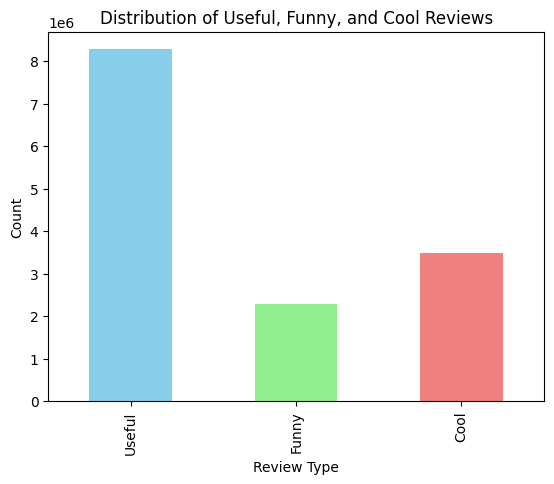

In [ ]:
#useful reviews
query_useful_reviews = """
    SELECT SUM(useful) AS UsefulCount
    FROM reviews
"""

#funny reviews
query_funny_reviews = """
    SELECT SUM(funny) AS FunnyCount
    FROM reviews
"""

#cool reviews
query_cool_reviews = """
    SELECT SUM(cool) AS CoolCount
    FROM reviews
"""
useful_count = spark.sql(query_useful_reviews).collect()[0]['UsefulCount']
funny_count = spark.sql(query_funny_reviews).collect()[0]['FunnyCount']
cool_count = spark.sql(query_cool_reviews).collect()[0]['CoolCount']

reviews_summary = spark.createDataFrame([
    ('Useful', useful_count),
    ('Funny', funny_count),
    ('Cool', cool_count)
], ['ReviewType', 'Count'])

reviews_summary_pd = reviews_summary.toPandas()
reviews_summary_pd.plot(kind='bar', x='ReviewType', y='Count', color=['skyblue', 'lightgreen', 'lightcoral'], legend=False)
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.title('Distribution of Useful, Funny, and Cool Reviews')
plt.show()


##### Top 10 negeative reviews





In [ ]:
query_top_ten_negative_reviews = """
    SELECT review_id, stars, text
    FROM reviews
    ORDER BY stars ASC
    LIMIT 10
"""

top_ten_negative_reviews = spark.sql(query_top_ten_negative_reviews)
top_ten_negative_reviews.show(truncate=False)


+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Top 10 positive reviews

In [ ]:
query_top_ten_positive_reviews = """
    SELECT review_id, stars, text
    FROM reviews
    ORDER BY stars DESC
    LIMIT 10
"""

top_ten_positive_reviews = spark.sql(query_top_ten_positive_reviews)
top_ten_positive_reviews.show(truncate=False)

+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id             |stars|text                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
+----------------------+----

##### Bar One

In [ ]:
query_restaurants = """
    SELECT name, city, state, categories
    FROM business
    WHERE lower(categories) LIKE '%restaurant%'
"""

# Execute the query using Spark SQL
restaurants = spark.sql(query_restaurants)

# Show the result
restaurants.show(truncate=False)

+------------------------------+------------+-----+-------------------------------------------------------------------------------------------------------------+
|name                          |city        |state|categories                                                                                                   |
+------------------------------+------------+-----+-------------------------------------------------------------------------------------------------------------+
|St Honore Pastries            |Philadelphia|PA   |Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries                                                        |
|Sonic Drive-In                |Ashland City|TN   |Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants                                 |
|Tsevi's Pub And Grill         |Affton      |MO   |Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek                                   |
|Sonic Drive-In             

In [ ]:
query_bar_one_info = """
    SELECT name, city, state, categories
    FROM business
    WHERE name = 'Bar One'
"""

bar_one_info = spark.sql(query_bar_one_info)
bar_one_info.show(truncate=False)


+-------+------------+-----+----------------------------------------------------+
|name   |city        |state|categories                                          |
+-------+------------+-----+----------------------------------------------------+
|Bar One|Philadelphia|PA   |Cocktail Bars, Bars, Italian, Nightlife, Restaurants|
+-------+------------+-----+----------------------------------------------------+



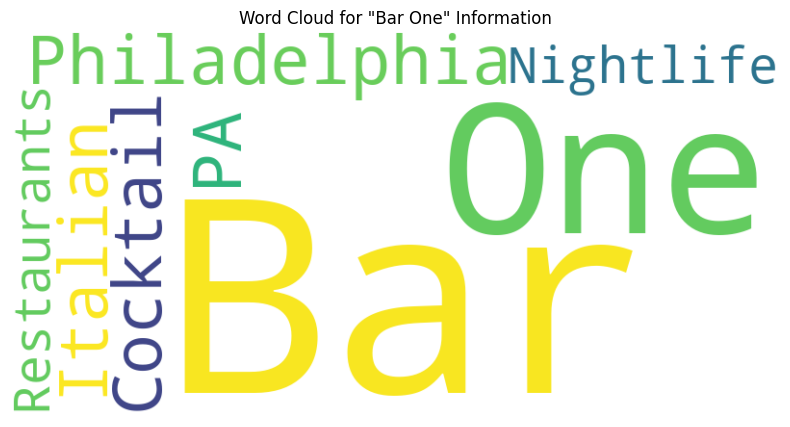

In [ ]:
from wordcloud import WordCloud

bar_one_info_df = bar_one_info.toPandas()
text = ' '.join(bar_one_info_df.iloc[0].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for "Bar One" Information')
plt.axis('off')
plt.show()

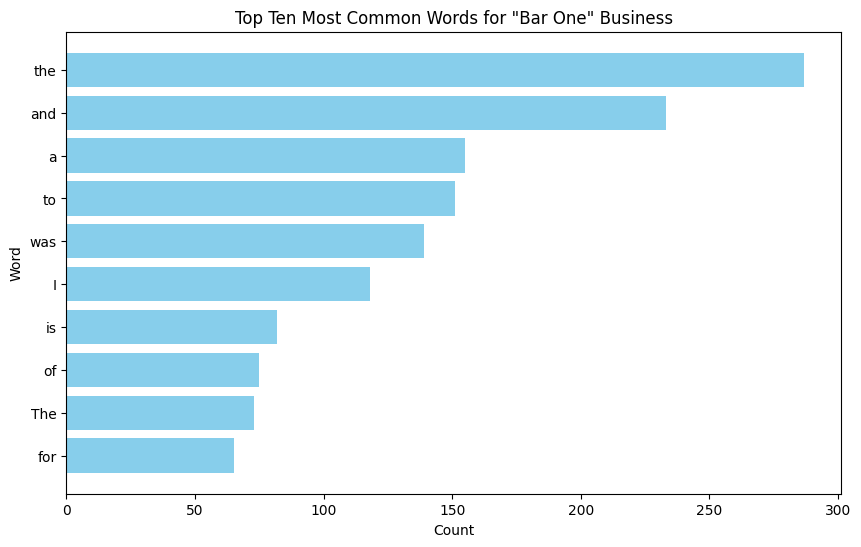

In [ ]:
from pyspark.sql.functions import split, explode

query_bar_one_reviews = """
    SELECT text
    FROM reviews
    WHERE business_id IN (
        SELECT business_id
        FROM business
        WHERE name = 'Bar One'
    )
"""

bar_one_reviews_df = spark.sql(query_bar_one_reviews)
words_df = bar_one_reviews_df.select(explode(split(bar_one_reviews_df.text, r'\s+')).alias('word'))

top_ten_words = words_df.groupBy('word').count().orderBy('count', ascending=False).limit(10)

top_ten_words_df = top_ten_words.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_ten_words_df['word'], top_ten_words_df['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top Ten Most Common Words for "Bar One" Business')
plt.gca().invert_yaxis()
plt.show()

##### Senitment Analysis

In [ ]:
query_negative_reviews = """
    SELECT *
    FROM reviews
    WHERE business_id = (SELECT business_id FROM business WHERE name = 'Bar One')
    AND stars < 3
"""

negative_reviews_df = spark.sql(query_negative_reviews)
negative_reviews_df.show(truncate=False)


+----------------------+----+-------------------+-----+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
query_positive_reviews = """
    SELECT *
    FROM reviews
    WHERE business_id = (SELECT business_id FROM business WHERE name = 'Bar One')
    AND stars >= 4
"""

positive_reviews_df = spark.sql(query_positive_reviews)
positive_reviews_df.show(truncate=False)


+----------------------+----+-------------------+-----+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 911.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=55afebb9ff4c7901d3d79491565301f863a02c9712c53996f45848a3235c04e4
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from afinn import Afinn

# Load the AFINN sentiment lexicon
afinn = Afinn()

# Define a UDF to calculate sentiment scores for reviews
def calculate_sentiment(review):
    # Split the review text into words
    words = review.split()
    # Calculate the sentiment score for each word and sum them up
    sentiment_score = sum(afinn.score(word) for word in words)
    return float(sentiment_score)

# Register the UDF (User Defined Function) for sentiment calculation
calculate_sentiment_udf = udf(calculate_sentiment, FloatType())

# Apply the sentiment analysis UDF to the positive reviews
positive_reviews_with_sentiment = positive_reviews_df.withColumn("sentiment_score", calculate_sentiment_udf("text"))

# Apply the sentiment analysis UDF to the negative reviews
negative_reviews_with_sentiment = negative_reviews_df.withColumn("sentiment_score", calculate_sentiment_udf("text"))

# Show the positive reviews with sentiment scores
positive_reviews_with_sentiment.show(truncate=False)

# Show the negative reviews with sentiment scores
negative_reviews_with_sentiment.show(truncate=False)


+----------------------+----+-------------------+-----+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

def calculate_sentiment(review):
    words = review.split()
    sentiment_score = sum(afinn.score(word) for word in words)
    return float(sentiment_score)

calculate_sentiment_udf = udf(calculate_sentiment, FloatType())

positive_reviews_with_sentiment = positive_reviews_df.withColumn("sentiment_score", calculate_sentiment_udf("text"))

negative_reviews_with_sentiment = negative_reviews_df.withColumn("sentiment_score", calculate_sentiment_udf("text"))

print("Positive Reviews:")
positive_reviews_with_sentiment.select("sentiment_score", "text").show(10, truncate=False)

print("Negative Reviews:")
negative_reviews_with_sentiment.select("sentiment_score", "text").show(10, truncate=False)

mean_positive_sentiment = positive_reviews_with_sentiment.agg({"sentiment_score": "mean"}).collect()[0][0]
mean_negative_sentiment = negative_reviews_with_sentiment.agg({"sentiment_score": "mean"}).collect()[0][0]

print("\nSummary Analysis:")
print(f"Mean Sentiment Score (Positive Reviews): {mean_positive_sentiment}")
print(f"Mean Sentiment Score (Negative Reviews): {mean_negative_sentiment}")

positive_sentiment_scores = positive_reviews_with_sentiment.select("sentiment_score").limit(10).collect()
negative_sentiment_scores = negative_reviews_with_sentiment.select("sentiment_score").limit(10).collect()




Positive Reviews:
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment_score|text                                                                                                                                                         